# Urbanization 
- This notebook version is focused on Freetown, Sierra Leone 
- Several different bands and indices were tested to evaluate urbanization extent

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
import numpy as np  

In [2]:
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

platform = "LANDSAT_7"
product = "ls7_ledaps_sierra_leone" 

# Get Coordinates
coordinates = api.get_full_dataset_extent(platform = platform, product = product)

time_extents = (min(coordinates['time'].values),max(coordinates['time'].values))
print( time_extents )

latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
print( latitude_extents )

longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
print( longitude_extents )

(numpy.datetime64('2000-01-02T11:02:56.000000000'), numpy.datetime64('2018-01-03T11:13:03.000000000'))
(6.284209485825666, 11.08498602721977)
(-14.7091492094735, -8.815572124947415)


# Visualize Data Cube Region

In [3]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

In [4]:
# Urbanization near Freetown
latitude_extents =  (8.33, 8.51) 
longitude_extents =  (-13.31, -13.13)
time_extents = ('2015-01-01', '2017-01-01')

# # City of Kenema
# latitude_extents =  (7.8198, 7.9294) 
# longitude_extents =  (-11.2315, -11.1419)
# time_extents = ('2016-01-01', '2018-01-01')

In [5]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## Load the dataset and the required spectral bands or other parameters

In [6]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
#view the dimensions and sample content from the cube
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 669, longitude: 669, time: 32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-11T11:09:05 ... 2016-12-31T11:12:50
  * latitude   (latitude) float64 8.51 8.51 8.509 8.509 ... 8.331 8.33 8.33 8.33
  * longitude  (longitude) float64 -13.31 -13.31 -13.31 ... -13.13 -13.13 -13.13
Data variables:
    red        (time, latitude, longitude) int16 3219 3193 3193 ... 513 486 486
    green      (time, latitude, longitude) int16 3129 3157 3102 ... 532 532 565
    blue       (time, latitude, longitude) int16 3211 3211 3263 ... 463 525 465
    nir        (time, latitude, longitude) int16 3289 3329 3329 ... 2190 2106
    swir1      (time, latitude, longitude) int16 2183 2220 2183 ... 1290 1329
    swir2      (time, latitude, longitude) int16 2013 1935 1974 ... 568 608 646
    pixel_qa   (time, latitude, longitude) int32 224 224 224 224 ... 66 66 66 66
Attributes:
    crs:      EPSG:4326

>### Define Cloud Masking Function   

In [8]:
def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def remove_clouds(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return dataset.where(a_clean_mask)

In [9]:
cloud_mask = generate_cloud_mask(landsat_dataset)
cloudless = remove_clouds(landsat_dataset) #landsat_dataset.where(image_is_clean)

> **Median Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series  

In [10]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def median_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [11]:
median_composite = median_mosaic(landsat_dataset)

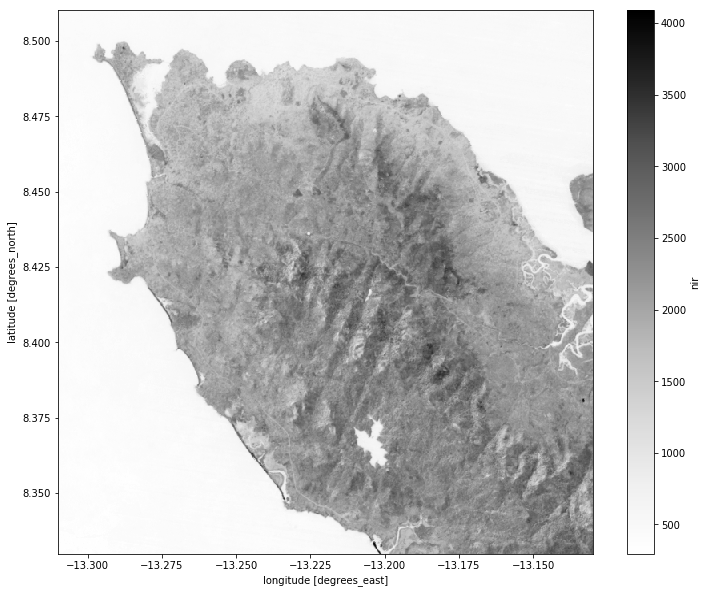

In [12]:
median_composite.nir.plot(figsize=(12,10), cmap = "Greys")

In [13]:
from utils.data_cube_utilities.dc_rgb import rgb

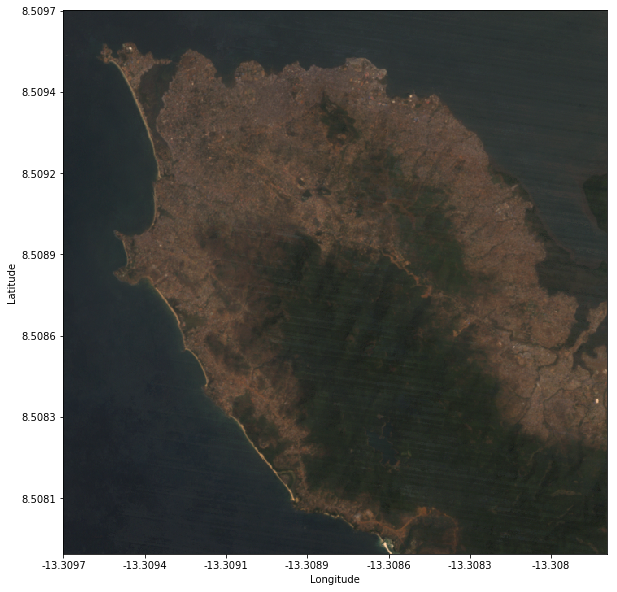

In [14]:
rgb(median_composite)

# Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  

In [15]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(median_composite, clean_mask = np.ones(median_composite.pixel_qa.shape).astype(np.bool)) 

## Plotting Fractional Cover Results
Plot Bare Soil (bs), Photosynthetic Vegetation (pv) or Non Photosynthetic Vegetation (npv)
<br>
Plot a False Color RGB result where RGB = bs/pv/npv.

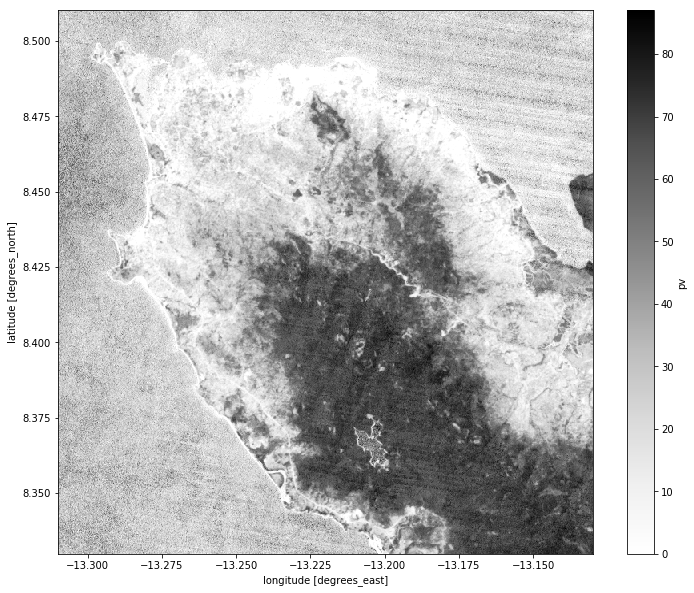

In [16]:
#frac_classes.bs.plot(figsize=(12,10), cmap = "Greys")
frac_classes.pv.plot(figsize=(12,10), cmap = "Greys")
#frac_classes.npv.plot(cmap = "Greys")

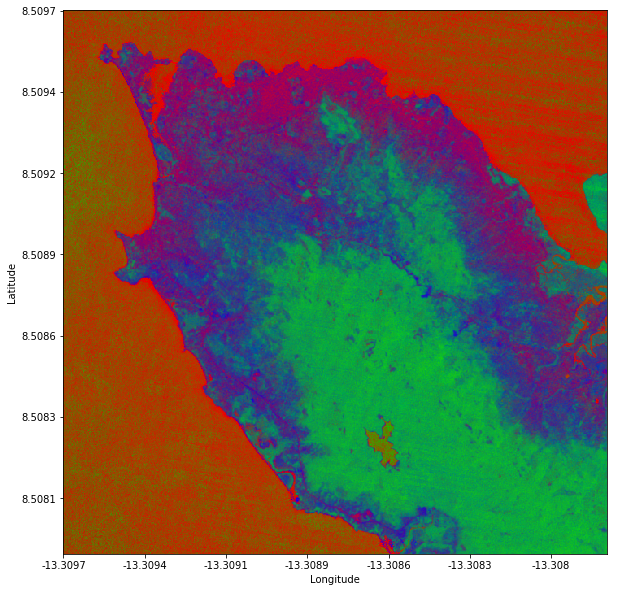

In [17]:
rgb(frac_classes, bands = ['bs', 'pv', 'npv']) 

# Spectral Indices

In [18]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [19]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [20]:
def BU(dataset):
        return NDBI(dataset)-NDVI(dataset)

In [21]:
landsat_mosaic = median_mosaic(landsat_dataset)  

ndbi = NDBI(landsat_mosaic)  # Urbanization - Reds
ndvi = NDVI(landsat_mosaic)  # Dense Vegetation - Greens
bu = BU(landsat_mosaic) # Build-Up Index = NDBI - NDVI

In [22]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


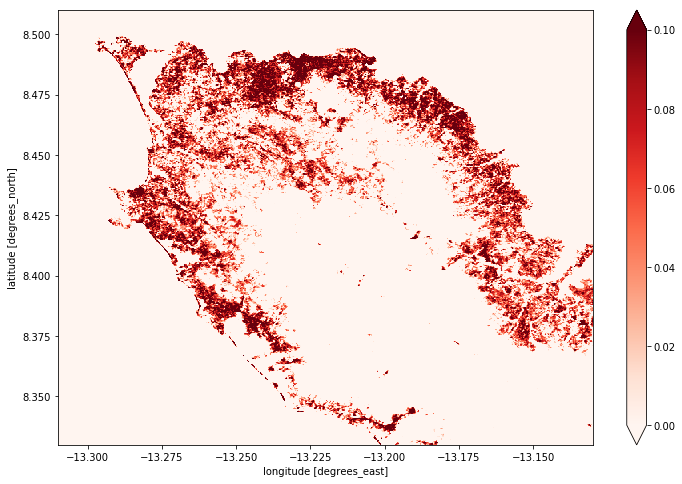

In [23]:
# May try cmap=GnBu or cmap=Greys, or cmap=Greens
(ndbi).plot(figsize=(12,8),cmap = "Reds", vmin=0.0, vmax=0.1)

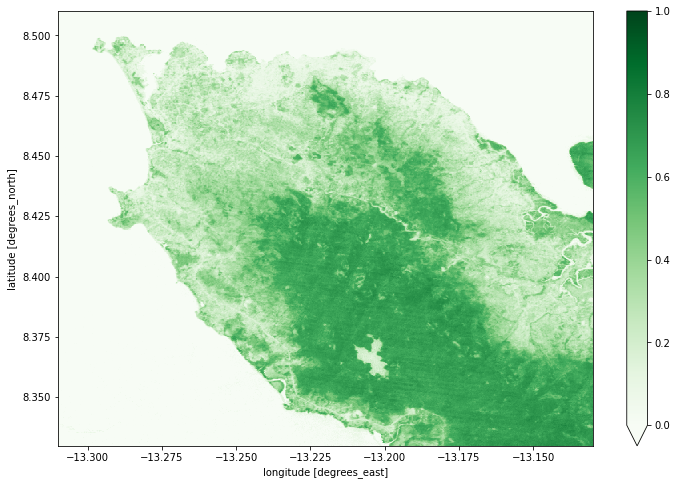

In [24]:
(ndvi).plot(figsize=(12,8), cmap = "Greens", vmin=0.0, vmax=1.0)

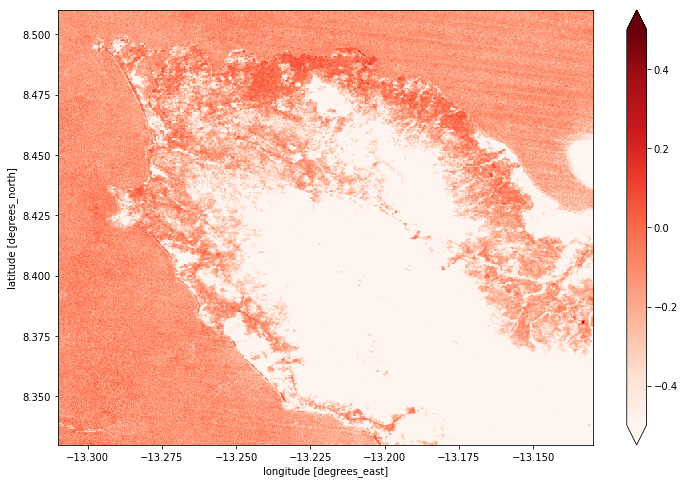

In [25]:
(bu).plot(figsize=(12,8), cmap = "Reds", vmin=-0.5, vmax=0.5)

## Create a threshold plot
First we will define a minimum threshold and a maximum threshold. Then you will create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold will be BLACK or WHITE. Also, we will calculate the % of pixels and the number of pixels in the threshold range.

In [26]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

### Plot Threshold Product

In [27]:
# Define the threshold region bounds
# NDVI range = 0.0 to 1.0
# NDBI range = 0.0 to 1.0
# BU range = -1.0 to 1.0
# NIR range =  0 to 4500
# Frac Cover (pv,npv,bs) = 0 to 100 
minimum_threshold = 0.0
maximum_threshold = 0.3

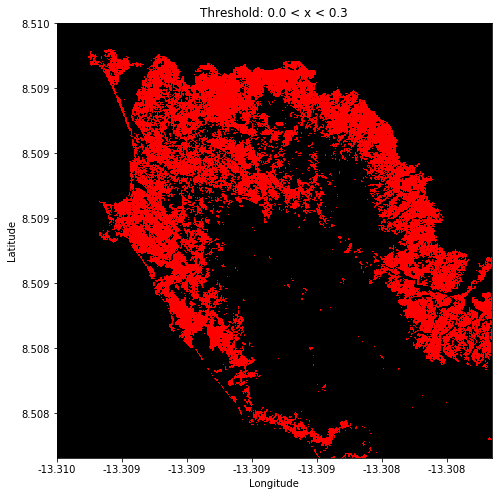

In [28]:
# Plot the threshold product using a cloud-filtered mosaic
# threshold_plot(ndvi, minimum_threshold, maximum_threshold, width = 8)
# threshold_plot(ui, minimum_threshold, maximum_threshold, width = 8)
threshold_plot(ndbi, minimum_threshold, maximum_threshold, width = 8)
# threshold_plot(median_composite.nir, minimum_threshold, maximum_threshold, width = 8)
# threshold_plot(bu, minimum_threshold, maximum_threshold, width = 8)
# threshold_plot(frac_classes.npv, minimum_threshold, maximum_threshold, width = 8)

In [29]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [30]:
threshold_count(ndbi,minimum_threshold,maximum_threshold)

{'inside': 93126,
 'outside': 354435,
 'total': 447561,
 'total_non_cloudy': 447561}

In [31]:
threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

{'percent_clouds': 0.0,
 'percent_inside_threshold': 20.80744300776877,
 'percent_outside_threshold': 79.19255699223122}